In [1]:
import pandas as pd
import numpy as np


from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
raw_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Train_raw.csv')
raw_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Test_raw.csv')

Adasyn_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_train.csv')
Adasyn_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Adasyn_test.csv')

Nearmiss_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_train.csv')
Nearmiss_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/Nearmiss_test.csv')

ROS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_train.csv')
ROS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/ROS_test.csv')

RUS_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_train.csv')
RUS_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/RUS_test.csv')

SMOTETomek_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_train.csv')
SMOTETomek_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/datasets/SMOTETomek_test.csv')

In [3]:
pip install neptune-client

In [4]:
import neptune

API_TOKEN='' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [5]:
raw_train.head()

,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,MonthAppointmentDate_0,MonthAppointmentDate_1,MonthAppointmentDate_2,DayAppointmentDate_0,DayAppointmentDate_1,DayAppointmentDate_2,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,NoShow
0,4652519881919,0,8,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0
1,81431485833737,0,74,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,12,0,0,1,1,0
2,555956674526286,0,50,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,31,0,0,0,1,0
3,14559326134688,0,21,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,5,0,0,1,0,0
4,16796474433112,0,39,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,1,0,0,1,0,0,0,0,1,4,0,0,0,1,1


In [6]:
!pip install eli5
!pip install hyperopt

In [7]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.float]).columns 
    return feats[ (feats != 'NoShow')].values

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='NoShow'):
    return df[target_var].values

In [8]:
feats = ['PatientId',
 	'Gender',
  'Age', 	
  'Neighbourhood_0', 	
  'Neighbourhood_1', 	
  'Neighbourhood_2', 	
  'Neighbourhood_3',	
  'Neighbourhood_4', 	
  'Neighbourhood_5', 
  'Neighbourhood_6', 
  'Neighbourhood_7',	
  'Scholarship', 	
  'Hypertension', 	
  'Diabetes', 	
  'Alcoholism', 	
  'Handicap', 	
  'SMSReceived', 	
  'MonthBookingDate_0', 	
  'MonthBookingDate_1',	
  'MonthBookingDate_2', 	
  'MonthBookingDate_3', 	
  'DayBookingDate_0', 	
  'DayBookingDate_1',	
  'DayBookingDate_2',	
  'DayBookingDate_3', 	
  'DayBookingDate_4', 	
  'DayBookingDate_5', 	
  'MonthAppointmentDate_0', 	
  'MonthAppointmentDate_1', 	
  'MonthAppointmentDate_2', 	
  'DayAppointmentDate_0',	
  'DayAppointmentDate_1',	
  'DayAppointmentDate_2',	
  'DayAppointmentDate_3', 	
  'DayAppointmentDate_4',
  'DayAppointmentDate_5', 	
  'HourOfDayBooking_0', 	
  'DaysToAppointment', 	
  'AppointmentWeekDay_0', 	
  'AppointmentWeekDay_1', 	
  'AppointmentWeekDay_2', 	
  'AppointmentWeekDay_3']

In [27]:
X_raw = get_X(raw_train)
y_raw = get_y(raw_train)

In [28]:
len(feats)

42

In [31]:
space4dt = {
    'max_depth': hp.choice('max_depth', range(2,50)),
    'max_features': hp.choice('max_features', range(1,len(feats))),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

In [32]:
def run_model(model):

  scores = cross_val_score(model, X_raw, y_raw, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
 

  print("Training with params: ")
  print(params)
  clf = DecisionTreeClassifier(**params)
  mean_f1, score_std = run_model(clf)
  print('loss: ',np.abs(mean_f1))
  return np.abs(mean_f1)

count = 0
best = 0

def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)
print('best:')
print(best)

Training with params: 
{'criterion': 'entropy', 'max_depth': 42, 'max_features': 11}
loss: 
0.32825894695042035
Training with params: 
{'criterion': 'gini', 'max_depth': 15, 'max_features': 25}
loss: 
0.22494833231550926
Training with params: 
{'criterion': 'gini', 'max_depth': 21, 'max_features': 23}
loss: 
0.31542480390427136
Training with params: 
{'criterion': 'gini', 'max_depth': 6, 'max_features': 34}
loss: 
0.0073769726004388565
Training with params: 
{'criterion': 'gini', 'max_depth': 17, 'max_features': 5}
loss: 
0.2564409549361803
Training with params: 
{'criterion': 'gini', 'max_depth': 26, 'max_features': 2}
loss: 
0.33018504271576704
Training with params: 
{'criterion': 'gini', 'max_depth': 15, 'max_features': 19}
loss: 
0.21899720621715374
Training with params: 
{'criterion': 'entropy', 'max_depth': 34, 'max_features': 37}
loss: 
0.3243169249634422
Training with params: 
{'criterion': 'entropy', 'max_depth': 29, 'max_features': 5}
loss: 
0.3246818667089701
Training with p

In [33]:
best

{'criterion': 0, 'max_depth': 38, 'max_features': 12}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


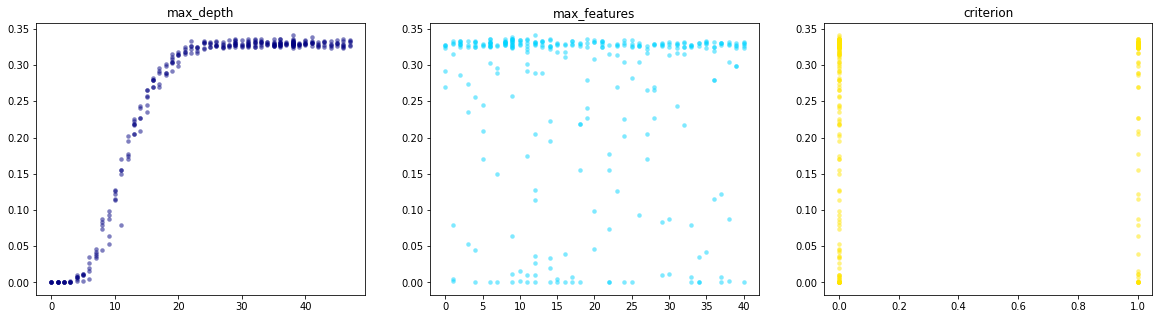

In [34]:
parameters = ['max_depth', 'max_features', 'criterion'] # decision tree
cols = len(parameters)

f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))

cmap = plt.cm.jet 

for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
   # xs, ys = zip(\*sorted(zip(xs, ys))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    #axes[i].set_ylim([0.9,1.0])

In [35]:
if best['criterion'] == 0: 
  best['criterion'] = 'gini'
else:
  best['criterion'] = 'entropy'

In [36]:
best

{'criterion': 'gini', 'max_depth': 38, 'max_features': 12}

In [37]:
clf = DecisionTreeClassifier(**best)

In [38]:
clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=38, max_features=12, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [39]:
def model(train, test, search, name, tags):
  
  #print(search.get_params())
  y_train = train["NoShow"]
  y_test = test["NoShow"]

  X_train = train.loc[:, train.columns != 'NoShow']
  X_test = test.loc[:, test.columns != 'NoShow']
                
  search = search.fit(X_train, y_train)

  #search.best_params_

  y_pred = search.predict(X_test)
  print(y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
        'recall', recall_score(y_test, y_pred), '\n',
        'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  neptune.append_tags([str(best),"Magdalena Cebula"])
  neptune.append_tags([str(feats)])
  neptune.append_tags([str(space4dt)])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, search.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

[1 0 0 ... 0 0 0]
Accuracy: 72.65%
 f1  0.33507388067992444 
 recall 0.3413309189678588 
 precision 0.3290421121536112
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-114
Confusion matrix:
 [[14390  3075]
 [ 2910  1508]]


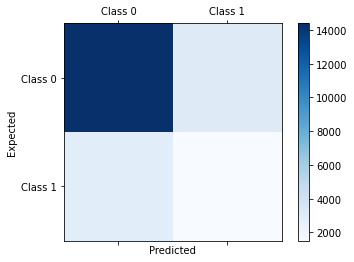

[0.         0.17606642 1.        ] [0.         0.34133092 1.        ] [2 1 0]


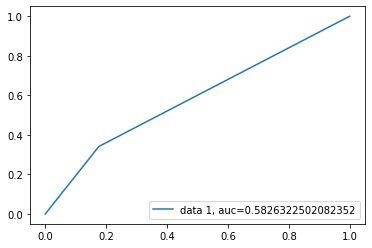

In [40]:
model(raw_train, raw_test, clf, 'DecissionTree', ['DecissionTree', 'Raw'])

In [41]:
X_neamiss = get_X(Nearmiss_train)
y_neamiss = get_y(Nearmiss_train)

def run_model(model):

  scores = cross_val_score(model, X_neamiss, y_neamiss, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

In [42]:
def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(DecisionTreeClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)

def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'gini', 'max_depth': 20, 'max_features': 34}
loss: 
0.7078876459194261
Training with params: 
{'criterion': 'gini', 'max_depth': 37, 'max_features': 6}
loss: 
0.6979727580871516
Training with params: 
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 3}
loss: 
0.6773652713658288
Training with params: 
{'criterion': 'gini', 'max_depth': 17, 'max_features': 19}
loss: 
0.7181531340902799
Training with params: 
{'criterion': 'gini', 'max_depth': 40, 'max_features': 17}
loss: 
0.7047810860311985
Training with params: 
{'criterion': 'entropy', 'max_depth': 25, 'max_features': 29}
loss: 
0.7047069930137241
Training with params: 
{'criterion': 'gini', 'max_depth': 48, 'max_features': 41}
loss: 
0.7041389653767958
Training with params: 
{'criterion': 'gini', 'max_depth': 19, 'max_features': 20}
loss: 
0.7090329035443066
Training with params: 
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 22}
loss: 
0.7633847413166339
Training with params: 

In [43]:
print('best:')
print(best)

best:
{'criterion': 1, 'max_depth': 3, 'max_features': 28}


In [44]:
def criterion(best):
  print(best)
  if best['criterion'] == 0: 
    best['criterion'] = 'gini'
  else:
    best['criterion'] = 'entropy'
  print(best)
  clf = DecisionTreeClassifier(**best)
  print(clf)
  return clf

In [45]:
clf = criterion(best)

{'criterion': 1, 'max_depth': 3, 'max_features': 28}
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 28}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=28, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[0 0 1 ... 1 1 0]
Accuracy: 78.60%
 f1  0.7861101685329714 
 recall 0.7865550022634676 
 precision 0.785665837666742
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-115
Confusion matrix:
 [[3470  948]
 [ 943 3475]]


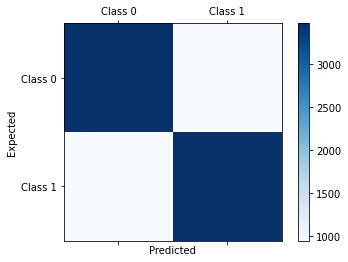

[0.         0.21457673 1.        ] [0.       0.786555 1.      ] [2 1 0]


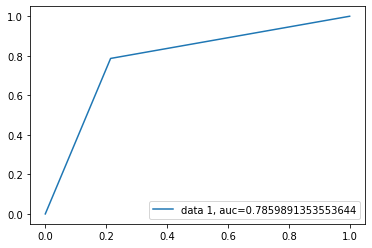

In [46]:
model(Nearmiss_train, Nearmiss_test,clf, "DecissionTree", ['DecissionTree', 'Nearmiss'])

In [47]:
X_ros = get_X(ROS_train)
y_ros = get_y(ROS_train)

def run_model(model):

  scores = cross_val_score(model, X_ros, y_ros, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(DecisionTreeClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)

def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'gini', 'max_depth': 7, 'max_features': 23}
loss: 
0.7168847996414808
Training with params: 
{'criterion': 'entropy', 'max_depth': 25, 'max_features': 37}
loss: 
0.8859376143537526
Training with params: 
{'criterion': 'gini', 'max_depth': 40, 'max_features': 23}
loss: 
0.9082110456846847
Training with params: 
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 3}
loss: 
0.6036141637562117
Training with params: 
{'criterion': 'entropy', 'max_depth': 17, 'max_features': 18}
loss: 
0.7998199403269004
Training with params: 
{'criterion': 'gini', 'max_depth': 25, 'max_features': 5}
loss: 
0.9005330374619535
Training with params: 
{'criterion': 'entropy', 'max_depth': 40, 'max_features': 6}
loss: 
0.908312710469301
Training with params: 
{'criterion': 'gini', 'max_depth': 34, 'max_features': 15}
loss: 
0.9084335146569937
Training with params: 
{'criterion': 'entropy', 'max_depth': 34, 'max_features': 21}
loss: 
0.9059597037076442
Training with param

In [48]:
clf = criterion(best)

{'criterion': 0, 'max_depth': 31, 'max_features': 14}
{'criterion': 'gini', 'max_depth': 31, 'max_features': 14}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=31, max_features=14, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[0 0 0 ... 1 0 1]
Accuracy: 57.19%
 f1  0.42360468701819304 
 recall 0.31462925851703405 
 precision 0.6480717065691709
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-116
Confusion matrix:
 [[14481  2984]
 [11970  5495]]


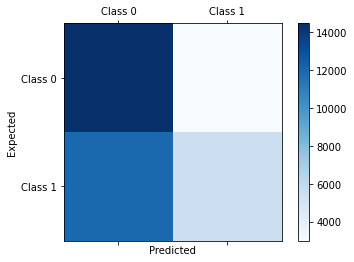

[0.       0.170856 1.      ] [0.         0.31462926 1.        ] [2 1 0]


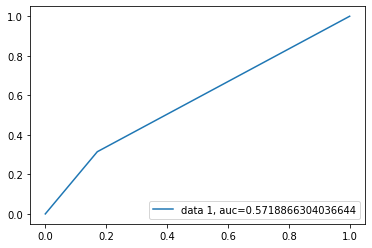

In [49]:
model(ROS_train, ROS_test,clf, "DecissionTree", ['DecissionTree', 'ROS'])

In [50]:
X_rus = get_X(RUS_train)
y_rus = get_y(RUS_train)

def run_model(model):

  scores = cross_val_score(model, X_rus, y_rus, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(DecisionTreeClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)


def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'entropy', 'max_depth': 47, 'max_features': 19}
loss: 
0.6032378339195831
Training with params: 
{'criterion': 'gini', 'max_depth': 25, 'max_features': 15}
loss: 
0.5990331727616498
Training with params: 
{'criterion': 'gini', 'max_depth': 46, 'max_features': 21}
loss: 
0.5982992195863351
Training with params: 
{'criterion': 'gini', 'max_depth': 49, 'max_features': 38}
loss: 
0.6017364642256701
Training with params: 
{'criterion': 'entropy', 'max_depth': 11, 'max_features': 25}
loss: 
0.6822114847299743
Training with params: 
{'criterion': 'entropy', 'max_depth': 25, 'max_features': 39}
loss: 
0.6068457801165821
Training with params: 
{'criterion': 'entropy', 'max_depth': 28, 'max_features': 36}
loss: 
0.6023484811334326
Training with params: 
{'criterion': 'gini', 'max_depth': 31, 'max_features': 37}
loss: 
0.6040370316279224
Training with params: 
{'criterion': 'gini', 'max_depth': 27, 'max_features': 6}
loss: 
0.6018814504679826
Training with par

In [53]:
best['max_depth']=2

In [54]:
clf = criterion(best)

{'criterion': 'gini', 'max_depth': 2, 'max_features': 35}
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 35}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=35, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[1 1 1 ... 1 1 1]
Accuracy: 66.31%
 f1  0.7320673206732067 
 recall 0.9205522861023088 
 precision 0.6076497833557448
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-117
Confusion matrix:
 [[1792 2626]
 [ 351 4067]]


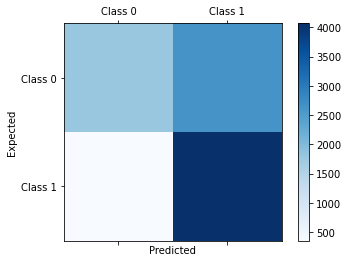

[0.        0.5943866 1.       ] [0.         0.92055229 1.        ] [2 1 0]


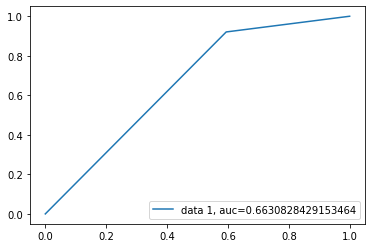

In [55]:
model(RUS_train, RUS_test,clf, "DecissionTree", ['DecissionTree', 'RUS'])

In [56]:
X_tomek = get_X(SMOTETomek_train)
y_tomek = get_y(SMOTETomek_train)

def run_model(model):

  scores = cross_val_score(model, X_tomek, y_tomek, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(DecisionTreeClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)


def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best2 = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'entropy', 'max_depth': 42, 'max_features': 33}
loss: 
0.8051605547638886
Training with params: 
{'criterion': 'gini', 'max_depth': 4, 'max_features': 11}
loss: 
0.7221471364648255
Training with params: 
{'criterion': 'entropy', 'max_depth': 48, 'max_features': 15}
loss: 
0.8056939629086284
Training with params: 
{'criterion': 'gini', 'max_depth': 9, 'max_features': 32}
loss: 
0.780747231826351
Training with params: 
{'criterion': 'gini', 'max_depth': 42, 'max_features': 40}
loss: 
0.8021866732994326
Training with params: 
{'criterion': 'gini', 'max_depth': 7, 'max_features': 9}
loss: 
0.765985249732075
Training with params: 
{'criterion': 'entropy', 'max_depth': 42, 'max_features': 7}
loss: 
0.8053608576376208
Training with params: 
{'criterion': 'gini', 'max_depth': 26, 'max_features': 40}
loss: 
0.8034528375791848
Training with params: 
{'criterion': 'entropy', 'max_depth': 13, 'max_features': 26}
loss: 
0.7918617967366018
Training with params: 


In [57]:
clf = criterion(best2)

{'criterion': 1, 'max_depth': 40, 'max_features': 12}
{'criterion': 'entropy', 'max_depth': 40, 'max_features': 12}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=40, max_features=12, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[0 0 0 ... 1 1 1]
Accuracy: 83.03%
 f1  0.827627672766901 
 recall 0.8147380881917727 
 precision 0.8409316533027873
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-118
Confusion matrix:
 [[11433  2083]
 [ 2504 11012]]


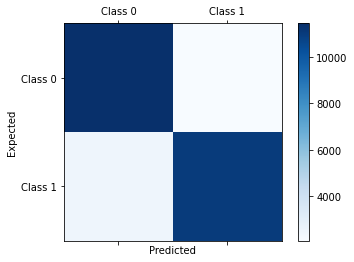

[0.         0.15411364 1.        ] [0.         0.81473809 1.        ] [2 1 0]


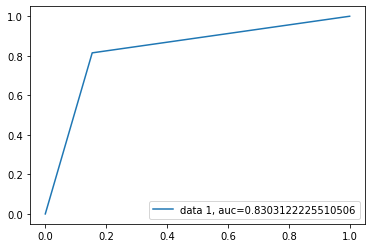

In [58]:
model(SMOTETomek_train, SMOTETomek_test,clf, "DecissionTree", ['DecissionTree', 'SMOTETomek'])

In [59]:
X_adasyn  = get_X(Adasyn_train)
y_adasyn = get_y(Adasyn_train)

def run_model(model):

  scores = cross_val_score(model, X_adasyn, y_adasyn, cv = 7, scoring='f1')
  
  return np.mean(scores), np.std(scores)

def hyperopt_train_test(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(DecisionTreeClassifier(**params))
  print('loss: ',np.abs(mean_mae))
  return np.abs(mean_mae)


def f(params):
  f1 = hyperopt_train_test(params)
  return {'loss': -f1, 'status': STATUS_OK}
  
trials = Trials()

best2 = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)

Training with params: 
{'criterion': 'entropy', 'max_depth': 47, 'max_features': 3}
loss: 
0.7639051055250474
Training with params: 
{'criterion': 'entropy', 'max_depth': 34, 'max_features': 14}
loss: 
0.7717092728287359
Training with params: 
{'criterion': 'entropy', 'max_depth': 35, 'max_features': 27}
loss: 
0.7679476158562396
Training with params: 
{'criterion': 'gini', 'max_depth': 17, 'max_features': 37}
loss: 
0.7660709470919561
Training with params: 
{'criterion': 'entropy', 'max_depth': 45, 'max_features': 12}
loss: 
0.7713078101136388
Training with params: 
{'criterion': 'gini', 'max_depth': 23, 'max_features': 13}
loss: 
0.7704283014705772
Training with params: 
{'criterion': 'gini', 'max_depth': 28, 'max_features': 40}
loss: 
0.7697273520583305
Training with params: 
{'criterion': 'gini', 'max_depth': 21, 'max_features': 30}
loss: 
0.7694317684421391
Training with params: 
{'criterion': 'gini', 'max_depth': 6, 'max_features': 25}
loss: 
0.7506188092040065
Training with para

In [60]:
clf = criterion(best2)

{'criterion': 1, 'max_depth': 31, 'max_features': 36}
{'criterion': 'entropy', 'max_depth': 31, 'max_features': 36}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=31, max_features=36, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[0 0 1 ... 1 1 1]
Accuracy: 80.67%
 f1  0.8055843408175014 
 recall 0.8008814102564102 
 precision 0.8103428306694463
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-119
Confusion matrix:
 [[14190  3275]
 [ 3479 13993]]


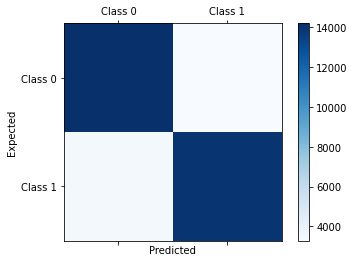

[0.         0.18751789 1.        ] [0.         0.80088141 1.        ] [2 1 0]


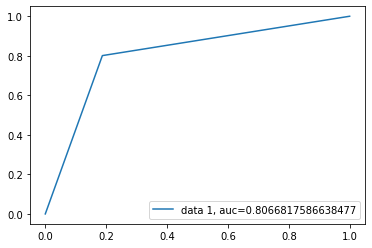

In [61]:
model(Adasyn_train, Adasyn_test,clf, "DecissionTree", ['DecissionTree', 'Adasyn'])